# PiLoc

* Implementation of `PiLoc: a Self-Calibrating Participatory Indoor Localization System`

## Imports

In [1]:
import sys
import os

PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
INDOOR_COMPETITION_20_DIR = os.path.join(PROJECT_HOME, "code",
                                         "indoor-location-competition-20")
print("The library is located at", INDOOR_COMPETITION_20_DIR)
sys.path.append(INDOOR_COMPETITION_20_DIR)

CODE_DIR = os.path.join(PROJECT_HOME, "code")
print(f"The code is located in {CODE_DIR}")
sys.path.append(CODE_DIR)

The library is located at ./../../code/indoor-location-competition-20
The code is located in ./../../code


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from tqdm import tqdm
from io_f import read_data_file
from py_indoor_loc.floor_map import read_floor_data, extract_floor_map_geometries, scale
from py_indoor_loc.zee import create_search_grid, SearchGrid
from shapely import ops as shapely_ops
from shapely import vectorized as shapely_vectorized
from shapely.geometry import LineString
from py_indoor_loc.plot import plot_floor_map
from py_indoor_loc.sensors import estimate_acceleration_heading
from py_indoor_loc.pdr.step_detection import compute_mean, compute_local_acc_variance, compute_step_positions
from compute_f import compute_step_heading
from compute_f import compute_rel_positions
from compute_f import correct_positions
from scipy.interpolate import interp1d
from dataclasses import dataclass

In [3]:
from py_indoor_loc.plot import plot_waypoint_location

In [4]:
from py_indoor_loc.pdr import filter_headings, detect_turn_points

In [5]:
%matplotlib inline

## Utilities

In [6]:
def get_track_filepaths(assignment_df: pd.DataFrame,
                        base_data_dir: str,
                        suffix: str = ".txt") -> list[str]:

  if not base_data_dir.endswith("/"):
    base_data_dir += "/"

  result = []

  for _, row in assignment_df.iterrows():
    file_path = f"{base_data_dir}{row['site_id']}/{row['floor_id']}/{row['track_id']}{suffix}"
    if not os.path.exists(file_path):
      print(f"File {file_path} does not exist.")
      continue
    result.append(file_path)

  return result

## Env Variables

In [7]:
TRAIN_DATA_DIR = "../../data/train/"
SUPERVISION_PCT = 0.1

In [8]:
WIFI_DATA_DIR = "../../data/wifi_fingerprint_manual/train/"

## Read Train/Test Assignment

In [7]:
supervision_df = pd.read_csv(
    "../../data/output/20230903_semi_supervision_setup.csv", index_col=0)
supervision_df["site_id"] = supervision_df["site_id"].astype("category")
supervision_df["floor_id"] = supervision_df["floor_id"].astype("category")
supervision_df["dataset"] = supervision_df["dataset"].astype("category")


FileNotFoundError: [Errno 2] No such file or directory: '../../data/output/20230903_semi_supervision_setup.csv'

In [9]:
train_test_assignment = pd.read_csv(
    "../../data/output/20230903_train_test_assignment.csv")
train_test_assignment["site_id"] = train_test_assignment["site_id"].astype(
    "category")
train_test_assignment["floor_id"] = train_test_assignment["floor_id"].astype(
    "category")
train_test_assignment["dataset"] = train_test_assignment["dataset"].astype(
    "category")


In [10]:
supervision_floor_df = supervision_df.loc[
    (supervision_df["supervision_pct"] == SUPERVISION_PCT) &
    (supervision_df["dataset"] == "unlabeled")]

unique_floors = supervision_floor_df[["site_id",
                                      "floor_id"]].drop_duplicates().values

print("The number of floors:", unique_floors.shape[0])
print("The number of tracks:", supervision_floor_df.shape[0])

The number of floors: 137
The number of tracks: 6284


## PiLoc: Data Collection

* Data collection is the first step of PiLoc.
* Each trajectory is determined by a sequency of steps, i.e. the i-th trajectory $T_i = [s_1, s_2,..., s_n]$, in which $s_i$ is a discrete walking step detected by the linear accelerations from the corresponding phone accelerometer input.
* Each step $s_i$ consists for 4 elements: $s_i = (id_i, x_i, y_i, f_i)$
  * $id_i$ is the global step identifier.
  * $x_i$ and $y_i$ are the relative physical 2D position of the current step with respect to the initial step $s_1$
  * $f_i = (r_1, r_2, ..., r_k)$ represents the WiFi RSS measured at step $i$, where $r_j$ is the received signal strength of $AP_j$ detected.

### Reading Data

In [9]:
site_id, floor_id = unique_floors[10]

train_tracks = supervision_floor_df.loc[
    (supervision_floor_df["site_id"] == site_id) &
    (supervision_floor_df["floor_id"] == floor_id)]

test_tracks = train_test_assignment.loc[
    (train_test_assignment["site_id"] == site_id) &
    (train_test_assignment["floor_id"] == floor_id) &
    (train_test_assignment["dataset"] == "test")]

train_files = get_track_filepaths(train_tracks, base_data_dir=TRAIN_DATA_DIR)
test_files = get_track_filepaths(test_tracks, base_data_dir=TRAIN_DATA_DIR)

NameError: name 'unique_floors' is not defined

In [10]:
wifi_train_files = get_track_filepaths(train_tracks,
                                       base_data_dir=WIFI_DATA_DIR,
                                       suffix="_wifi_fingerprint.csv")


NameError: name 'train_tracks' is not defined

* Read data files for a specific sites

In [11]:
site_id, floor_id = "5cd56b6ae2acfd2d33b59ccb", "F2"

In [12]:
data_files = glob(f"{TRAIN_DATA_DIR}{site_id}/{floor_id}/*.txt")

* Read floor map data

In [13]:
floor_info, floor_map = read_floor_data(
  f"../../data/metadata/{site_id}/{floor_id}")

transform_func = lambda coords: coords

(
  floor_polygons,
  store_polygons,
  x_min,
  y_min,
  x_max,
  y_max,
  width_meter,
  height_meter,
) = extract_floor_map_geometries(floor_map, floor_info, transform=transform_func)


In [198]:
path_datas = read_data_file(data_files[1])

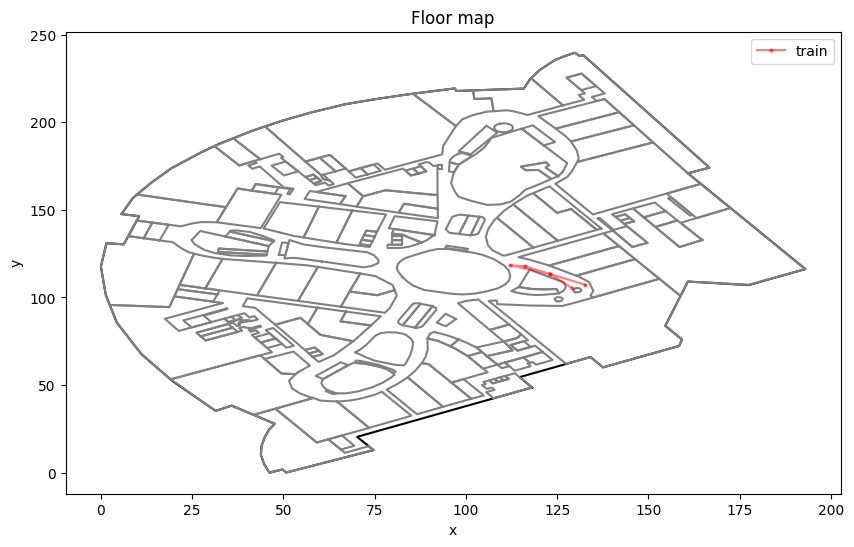

In [199]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_floor_map(floor_polygons, store_polygons, ax=ax)

waypoint_location = transform_func(path_datas.waypoint[:, 1:])
ax.plot(waypoint_location[:, 0],
        waypoint_location[:, 1],
        marker="o",
        markersize=2,
        color="red",
        label="train",
        alpha=0.5)
ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

### Step Detection

In [200]:
def compute_random_stride_length(size: int,
                                 stride_length_range: tuple[float,
                                                            float] = (0.5, 1.2),
                                 noise_pct: float = 0.15) -> np.ndarray:
  assert noise_pct >= 0 and noise_pct <= 1

  sl_low, sl_high = stride_length_range
  noise = np.random.normal(loc=0, scale=noise_pct, size=size)
  stride_length = np.random.uniform(low=sl_low, high=sl_high)
  return stride_length * (1 + noise)

In [201]:
def create_sensor_df(path_datas) -> pd.DataFrame:
  magn_df = pd.DataFrame(path_datas.magn,
                         columns=["ts", "magn_x", "magn_y", "magn_z"])
  acce_df = pd.DataFrame(path_datas.acce,
                         columns=["ts", "acce_x", "acce_y", "acce_z"])
  sensor_df = pd.merge(acce_df, magn_df, how="outer")
  sensor_df.ffill(inplace=True)
  sensor_df["ts"] = sensor_df["ts"].astype(np.int64)
  sensor_df.sort_values("ts", ascending=True, inplace=True)
  return sensor_df

In [202]:
sensor_df = create_sensor_df(path_datas)
acce, heading = estimate_acceleration_heading(
    acce=sensor_df[["ts", "acce_x", "acce_y", "acce_z"]].values,
    magn=sensor_df[["ts", "magn_x", "magn_y", "magn_z"]].values)
acce_magnitudes = np.linalg.norm(acce, axis=1)

acce_mean = compute_mean(acce_magnitudes, window_size=7)
acce_var = compute_local_acc_variance(acce_magnitudes, window_size=7)
is_step_flags, swing, stance = compute_step_positions(acce_var,
                                                      swing_threshold=2,
                                                      stance_threshold=1,
                                                      window_size=7)


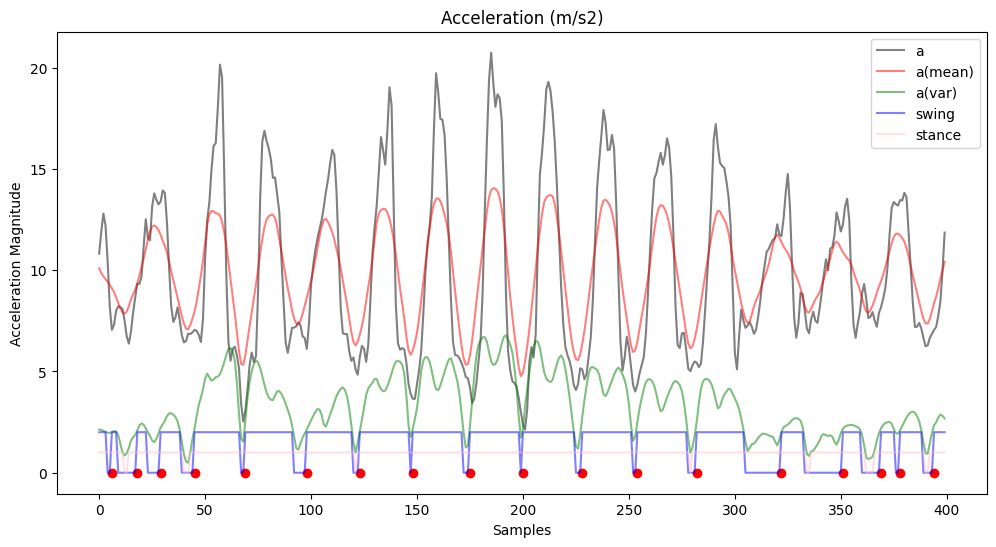

In [203]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

n_samples = 400
ax.plot(acce_magnitudes[:n_samples], alpha=0.5, label="a", color="black")
ax.plot(acce_mean[:n_samples], alpha=0.5, label="a(mean)", color="red")
ax.plot(acce_var[:n_samples], alpha=0.5, label="a(var)", color="green")
ax.plot(swing[:n_samples], alpha=0.5, label="swing", color="blue")
ax.plot(stance[:n_samples], alpha=0.5, label="stance", color="pink")

for i in range(n_samples):
  if is_step_flags[i]:
    ax.scatter(i, 0, marker="o", color="red")

ax.set_title("Acceleration (m/s2)")
ax.set_xlabel("Samples")
ax.set_ylabel("Acceleration Magnitude")
ax.legend()

plt.show()

In [231]:
sensor_timestamps = sensor_df["ts"].values
heading_with_timestamps = np.vstack((sensor_timestamps, heading)).T
step_timestamps = sensor_timestamps[is_step_flags]
step_headings = compute_step_heading(step_timestamps, heading_with_timestamps)
step_headings[:, 1] = filter_headings(np.radians(step_headings[:, 1]))
stride_lengths = np.zeros((len(step_timestamps), 2), dtype=np.float64)
stride_lengths[:, 0] = step_timestamps
stride_lengths[:, 1] = compute_random_stride_length(len(step_timestamps))
rel_positions = compute_rel_positions(stride_lengths, step_headings)
step_locations = correct_positions(rel_positions, path_datas.waypoint)

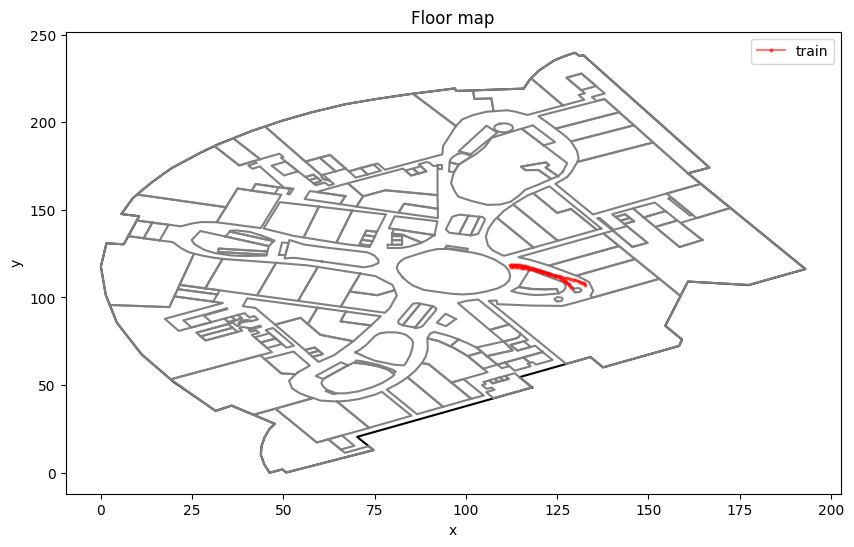

In [232]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_floor_map(floor_polygons, store_polygons, ax=ax)

waypoint_location = transform_func(step_locations[:, 1:])
ax.plot(waypoint_location[:, 0],
        waypoint_location[:, 1],
        marker="o",
        markersize=2,
        color="red",
        label="train",
        alpha=0.5)
ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

In [162]:
from compute_f import compute_headings, compute_stride_length, compute_steps

In [235]:
step_timestamps, step_indexs, step_acce_max_mins = compute_steps(path_datas.acce)
headings = compute_headings(path_datas.ahrs)
headings[:, 1] = headings[:, 1]
stride_lengths = compute_stride_length(step_acce_max_mins)
step_headings = compute_step_heading(step_timestamps, headings)
rel_positions_2 = compute_rel_positions(stride_lengths, step_headings)

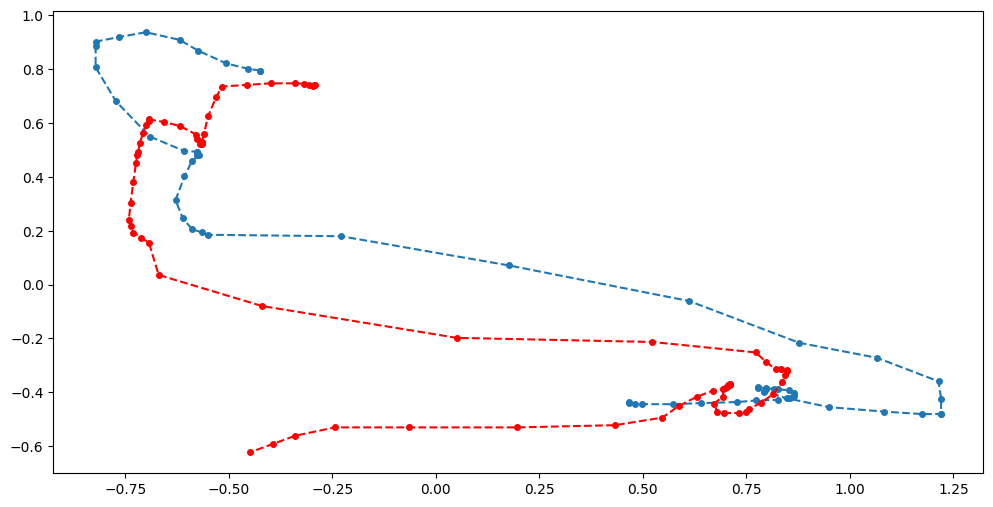

In [236]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(filter_headings(rel_positions_2[:, 1]),
        filter_headings(rel_positions_2[:, 2]),
        marker='o', markersize=4, ls="--")

ax.plot(filter_headings(rel_positions[:, 1]),
        filter_headings(rel_positions[:, 2]),
        marker='o', markersize=4, ls="--", color="red")

In [237]:
def moving_average(x: np.ndarray, w: int) -> np.ndarray:
  return np.convolve(x, np.ones(w), 'valid') / w


In [238]:
turn_point_mask = detect_turn_points(filter_headings(step_headings[:, 1]))

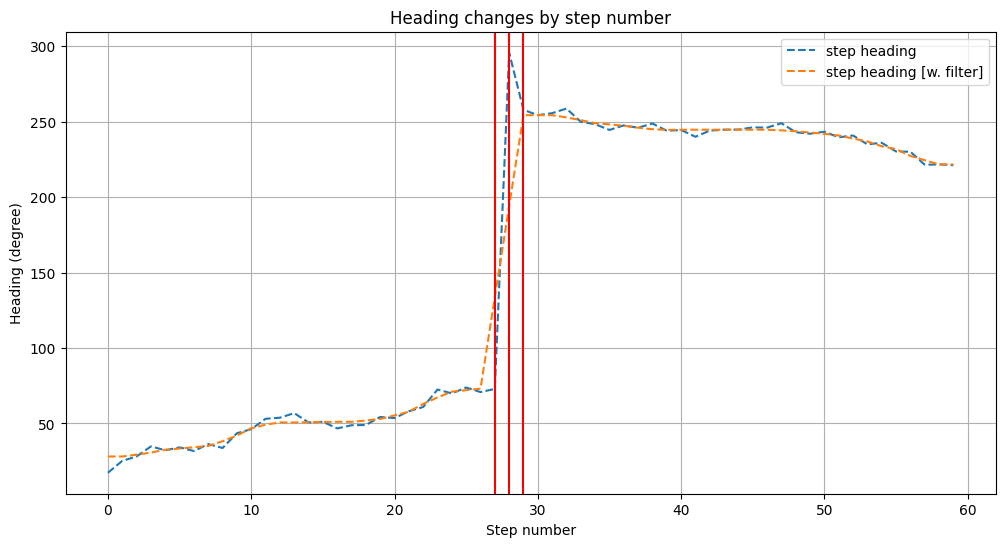

In [239]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

ax.plot(np.degrees(step_headings[:, 1]), label="step heading", ls="--")
ax.plot(np.degrees(filter_headings(step_headings[:, 1])),
        label="step heading [w. filter]",
        ls="--")

for x in np.where(turn_point_mask)[0]:
  ax.axvline(x=x, color="red")

ax.set_xlabel("Step number")
ax.set_ylabel("Heading (degree)")
ax.set_title("Heading changes by step number")
ax.grid()
ax.legend()

plt.show()

In [240]:
heading_f = filter_headings(step_headings[:, 1])

In [241]:
turn_indices = np.where(turn_point_mask)[0]

In [242]:
turn_indices

array([27, 28, 29])

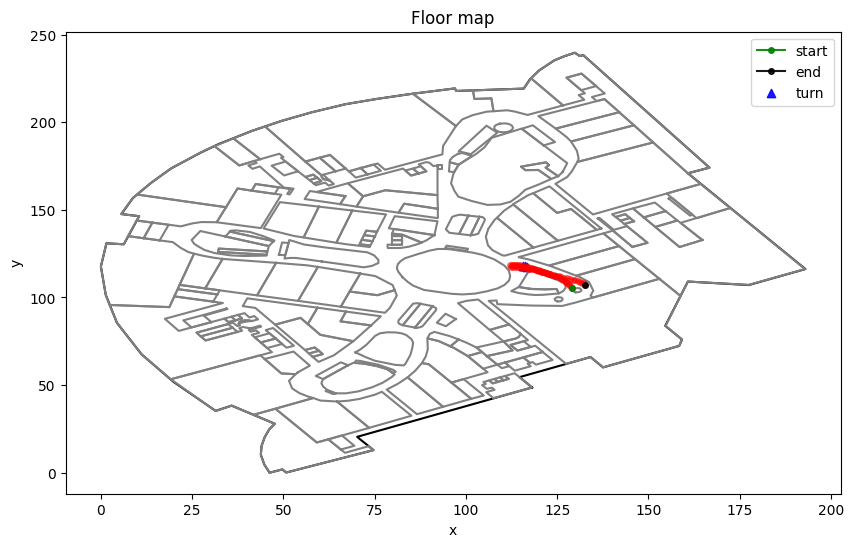

In [243]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

plot_floor_map(floor_polygons, store_polygons, ax=ax)

waypoint_location = transform_func(step_locations[:, 1:])

plot_waypoint_location(waypoint_location, ax=ax)

turn_indices = np.clip(turn_indices, a_min=0, a_max=len(waypoint_location) - 1)
ax.scatter(waypoint_location[turn_indices, 0],
           waypoint_location[turn_indices, 1],
           marker="^",
           color="blue",
           label="turn",
           alpha=0.9)

ax.legend()

plt.ticklabel_format(useOffset=False)
plt.show()

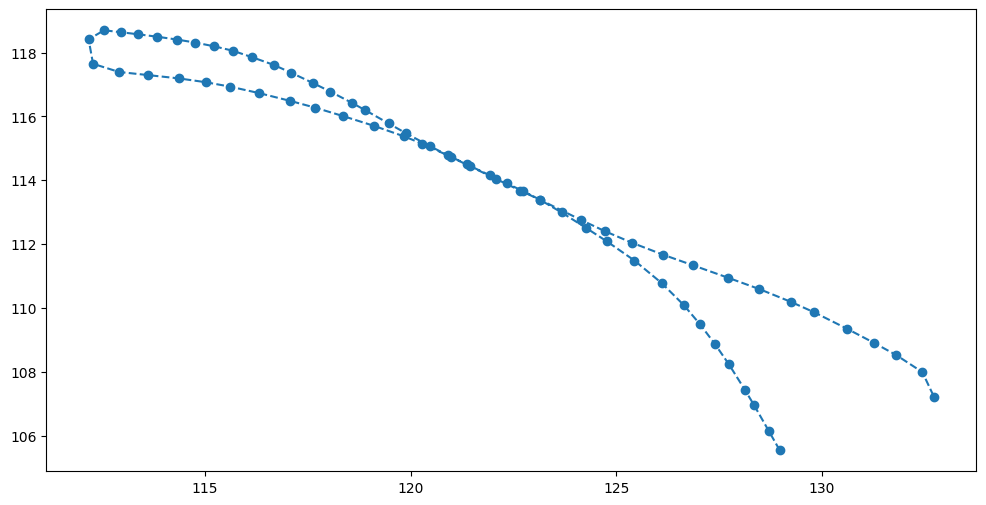

In [244]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

# ax.plot(rel_positions[:, 1], 
#         rel_positions[:, 2], 
#         marker="o", ls="--")

ax.plot(step_locations[:, 1], 
        step_locations[:, 2], 
        marker="o", ls="--")

plt.show()

* Segment Extraction

In [245]:
def split_segments(n_steps: int,
                   turn_indices: np.ndarray,
                   turn_window_n_steps: int = 10,
                   straight_line_min_n_steps: int = 30) -> list:

  turn_mask = np.array([False] * n_steps)
  for turn_index in turn_indices:
    turn_mask[turn_index - turn_window_n_steps:turn_index +
              turn_window_n_steps] = True

  step_flag_straight_line = False
  step_flag_turn = True

  segment_type = {True: "turn", False: "straight_line"}

  segments = []

  step_idx = 0
  step_flag = turn_mask[step_idx]
  step_start_idx, step_stop_idx = step_idx, step_idx

  while step_idx + 1 < n_steps:
    step_idx += 1
    if turn_mask[step_idx] == step_flag:
      step_stop_idx += 1
    else:
      if (step_flag == step_flag_straight_line and step_stop_idx - step_start_idx >= straight_line_min_n_steps) \
        or (step_flag == step_flag_turn):
        segments.append(
            (step_start_idx, step_stop_idx, segment_type[step_flag]))

      step_flag = turn_mask[step_idx]
      step_start_idx, step_stop_idx = step_idx, step_idx


  if (step_flag == step_flag_straight_line and step_stop_idx - step_start_idx >= straight_line_min_n_steps) \
        or (step_flag == step_flag_turn):
    segments.append((step_start_idx, step_stop_idx, segment_type[step_flag]))

  return segments


In [246]:
segments = split_segments(len(step_locations),
                          turn_indices,
                          turn_window_n_steps=5,
                          straight_line_min_n_steps=10)


In [247]:
segments

[(0, 21, 'straight_line'), (22, 33, 'turn'), (34, 69, 'straight_line')]

## PiLoc: Matching

### Path Correlation

In [248]:
def downsample(arr: np.ndarray,
               downsampling_factor: float = 2,
               kind: str = "linear") -> np.ndarray:
  interp_func = interp1d(np.arange(len(arr)), arr, kind=kind)
  new_indices = np.arange(0, len(arr) - 1, downsampling_factor)
  return interp_func(new_indices)


In [249]:
def compute_path_correlation(
    s1_x: np.ndarray,
    s1_y: np.ndarray,
    s2_x: np.ndarray,
    s2_y: np.ndarray,
) -> float:
  n1, n2 = len(s1_x), len(s2_x)

  if n1 > n2:
    return compute_path_correlation(s2_x, s2_y, s1_x, s1_y)

  # Perform downsampling to align the longer sequence
  downsampling_factor = n2 / n1
  d_s2_x = downsample(s2_x, downsampling_factor, "linear")
  d_s2_y = downsample(s2_y, downsampling_factor, "linear")

  n = min(n1, len(d_s2_x))
  corr_x = np.corrcoef(s1_x[:n], d_s2_x[:n])[0, 1]
  corr_y = np.corrcoef(s1_y[:n], d_s2_y[:n])[0, 1]

  return corr_x + corr_y


### Signal Correlation

In [250]:
from py_indoor_loc.extract.wifi_fingerprint import read_wifi_location_df_list
from py_indoor_loc.extract.wifi_fingerprint import extract_bssid_set, create_fingerprint_vector

In [251]:
def downsample_f(sf: np.ndarray, downsampling_factor: float = 2.0):
  downsampled = []

  for i in range(sf.shape[1]):
    downsampled.append(downsample(sf[:, i], downsampling_factor,
                                  kind="nearest"))

  return np.vstack(downsampled).T

In [339]:
def compute_signal_correlation(s1_f: np.ndarray,
                               s2_f: np.ndarray,
                               min_n_apps: int = 10,
                               default_rss: float = -100,
                               rss_sigma: float = 5):
  if len(s1_f) == 0 or len(s2_f) == 0:
    return 0.0

  if len(s1_f) > len(s2_f):
    return compute_signal_correlation(s2_f, s1_f, min_n_apps, default_rss,
                                      rss_sigma)

  # Aligning two RSS fingerprint signal
  downsampling_factor = len(s2_f) / len(s1_f)
  s2_f = downsample_f(s2_f, downsampling_factor)
  n = min(len(s1_f), len(s2_f))
  s1_f, s2_f = s1_f[:n], s2_f[:n]

  mu1 = s1_f.mean(axis=0)
  mu2 = s2_f.mean(axis=0)
  s1_ap_n_apps = np.count_nonzero(s1_f > default_rss, axis=0)
  s2_ap_n_apps = np.count_nonzero(s2_f > default_rss, axis=0)

  total_ap_n_apps = s1_ap_n_apps + s2_ap_n_apps
  selected_ap = (total_ap_n_apps >= min_n_apps) & (s1_ap_n_apps
                                                   > 0) & (s2_ap_n_apps > 0)
  selected_ap_indices = np.where(selected_ap)[0]

  if len(selected_ap_indices) == 0:
    return 0.0

  corr_signal = 0.0
  sum_w = 0.0
  for i in selected_ap_indices:
    i_12 = np.abs(mu1[i] - mu2[i]) < rss_sigma
    w = 2.0 / np.abs(mu1[i] + mu2[i])
    if s1_f[:, i].std() == 0 or s2_f[:, i].std() == 0:
      continue
    f_corr = np.corrcoef(s1_f[:, i], s2_f[:, i])[0, 1]
    corr_signal += w * f_corr * i_12
    sum_w += w

  return corr_signal / (w + 1e-6)

## Matching

In [253]:
WIFI_LOCATION_DATA_DIR = "../../data/wifi_location/"

In [254]:
def to_text(v: np.ndarray, sep: str = ","):
  return sep.join([str(vv) for vv in v])


def to_array(v_text: str, sep: str = ",") -> np.ndarray:
  return np.array([float(vv) for vv in v_text.split(sep)], dtype=np.float32)

In [255]:
def create_matrix(wifi_fingerprint_location_df):

  F = np.vstack(wifi_fingerprint_location_df["v"].values.tolist())

  m = np.zeros((F.shape[0], F.shape[1] + 1))
  m[:, 0] = wifi_fingerprint_location_df["sys_ts"].values
  m[:, 1:] = F

  return m

In [256]:
@dataclass
class Segment(object):
  segment_id: int
  track_id: str
  rel_step_positions: np.ndarray
  wifi_f: np.ndarray
  kind: str
  step_positions: np.ndarray

In [257]:
def read_wifi_fingerprint_location_df(site_id: str, floor_id: str,
                                      track_id: str,
                                      data_dir: str) -> pd.DataFrame:
  if not data_dir.endswith("/"):
    data_dir += "/"

  wifi_fingerprint_location_df = pd.read_csv(
      f"{data_dir}{site_id}/{floor_id}/{track_id}.csv",
      sep="|",
  )
  wifi_fingerprint_location_df["v"] = wifi_fingerprint_location_df["v"].apply(
      lambda vv: to_array(str(vv), sep=","))

  return wifi_fingerprint_location_df

In [258]:
data_stats = []

for data_file in data_files:
  path_datas = read_data_file(data_file)
  track_id = os.path.basename(data_file)[:-len(".txt")]
  wifi_fingerprint_location_df = read_wifi_fingerprint_location_df(
      site_id, floor_id, track_id, data_dir=WIFI_LOCATION_DATA_DIR)
  locations = wifi_fingerprint_location_df[["x", "y"]].values
  distance = np.linalg.norm(locations[1:] - locations[:-1], axis=1).sum()
  n_wifi_points = wifi_fingerprint_location_df.shape[0]
  duration = (wifi_fingerprint_location_df["sys_ts"].values[-1] -
              wifi_fingerprint_location_df["sys_ts"].values[0]) / 1000

  data_stats.append({
      "track_id": track_id,
      "n_wifi_points": n_wifi_points,
      "duration": duration,
      "distance": distance
  })

In [259]:
data_stats_df = pd.DataFrame(data_stats)

In [260]:
data_stats_df.head()

,track_id,n_wifi_points,duration,distance
0,5df5ffe560c20f0006ec06f6,15,26.524,26.778057
1,5d04a34edb9d650008324474,36,36.952,45.939757
2,5df5ffc713d568000671a93c,12,23.841,24.941462
3,5df6000213d568000671a952,18,33.212,39.711584
4,5df5ffcd60c20f0006ec06eb,31,67.142,78.118677


In [261]:
tracks = data_stats_df.loc[(data_stats_df["n_wifi_points"] >= 10) &
                           (data_stats_df["distance"] >= 10) &
                           (data_stats_df["duration"] >= 10), "track_id"].values


In [262]:
track_set = set(tracks)

In [264]:
result = []

segmend_id_gen = 0

for data_file in tqdm(data_files):

  track_id = os.path.basename(data_file[:-len(".txt")])
  if track_id not in track_set:
    continue

  try:

    path_datas = read_data_file(data_file)

    sensor_df = create_sensor_df(path_datas)
    acce, heading = estimate_acceleration_heading(
        acce=sensor_df[["ts", "acce_x", "acce_y", "acce_z"]].values,
        magn=sensor_df[["ts", "magn_x", "magn_y", "magn_z"]].values)
    acce_magnitudes = np.linalg.norm(acce, axis=1)

    acce_mean = compute_mean(acce_magnitudes, window_size=7)
    acce_var = compute_local_acc_variance(acce_magnitudes, window_size=7)
    is_step_flags, swing, stance = compute_step_positions(acce_var,
                                                          swing_threshold=2.0,
                                                          stance_threshold=1.0,
                                                          window_size=7)

    sensor_timestamps = sensor_df["ts"].values
    heading_with_timestamps = np.vstack((sensor_timestamps, heading)).T
    step_timestamps = sensor_timestamps[is_step_flags]
    step_headings = compute_step_heading(step_timestamps,
                                         heading_with_timestamps)
    step_headings[:, 1] = filter_headings(np.radians(step_headings[:, 1]))
    stride_lengths = np.zeros((len(step_timestamps), 2), dtype=np.float64)
    stride_lengths[:, 0] = step_timestamps
    stride_lengths[:, 1] = compute_random_stride_length(len(step_timestamps))
    rel_positions = compute_rel_positions(stride_lengths, step_headings)
    step_positions = correct_positions(rel_positions, path_datas.waypoint)

    turn_point_mask = detect_turn_points(step_headings[:, 1])
    turn_indices = np.where(turn_point_mask)[0]

    straight_line_segments = split_segments(len(step_timestamps),
                                            turn_indices,
                                            turn_window_n_steps=5,
                                            straight_line_min_n_steps=20)
    wifi_fingerprint_location_df = read_wifi_fingerprint_location_df(
        site_id, floor_id, track_id, data_dir=WIFI_LOCATION_DATA_DIR)
    Fm = create_matrix(wifi_fingerprint_location_df)

    for s_start_idx, s_end_idx, s_type in straight_line_segments:
      segment = Segment(
          segment_id=segmend_id_gen,
          track_id=track_id,
          rel_step_positions=rel_positions[s_start_idx:s_end_idx + 1, :],
          wifi_f=Fm[(Fm[:, 0] >= step_timestamps[s_start_idx]) &
                    (Fm[:, 0] <= step_timestamps[s_end_idx])],
          kind=s_type,
          step_positions=step_positions[s_start_idx:s_end_idx + 1, :])
      segmend_id_gen += 1

      result.append(segment)
  except Exception as ignored:
    print(site_id, floor_id, track_id)

100%|██████████| 132/132 [00:39<00:00,  3.38it/s]


In [265]:
turn_segments = []
straight_line_segments = []

for segment in result:
  if segment.kind == "turn":
    turn_segments.append(segment)
  else:
    straight_line_segments.append(segment)

In [266]:
print(len(turn_segments))

275


In [267]:
print(len(straight_line_segments))

109


* Cluster into turn segments and straight line segments

In [268]:
def compute_path_correlation_max(
    s1_x: np.ndarray,
    s1_y: np.ndarray,
    s2_x: np.ndarray,
    s2_y: np.ndarray,
) -> float:
  n1, n2 = len(s1_x), len(s2_x)

  if n1 > n2:
    return compute_path_correlation(s2_x, s2_y, s1_x, s1_y)

  corr_max = -np.inf
  for j in range(0, n2 - n1 + 1):
    corr_x = np.corrcoef(s1_x, s2_x[j:j + n1])[0, 1]
    corr_y = np.corrcoef(s1_y, s2_y[j:j + n1])[0, 1]
    corr_max = np.max([corr_max, corr_x + corr_y])

  return corr_max


In [269]:
def compute_signal_correlation_max(s1_f: np.ndarray,
                                   s2_f: np.ndarray,
                                   min_n_apps: int = 10,
                                   default_rss: float = -100,
                                   rss_sigma: float = 5):
  n1, n2 = len(s1_f), len(s2_f)

  if n1 > n2:
    return compute_signal_correlation_max(s2_f, s1_f, min_n_apps, default_rss,
                                          rss_sigma)

  corr_max = -np.inf
  for j in range(0, n2 - n1 + 1):
    corr = compute_signal_correlation(s1_f, s2_f[j:j + n1], min_n_apps,
                                      default_rss, rss_sigma)
    corr_max = np.max([corr_max, corr])

  return corr_max

In [270]:
def compute_segment_correlations(s1: Segment, s2: Segment) -> tuple:
  path_corr = compute_path_correlation(s1.rel_step_positions[:, 1],
                                       s1.rel_step_positions[:, 2],
                                       s2.rel_step_positions[:, 1],
                                       s2.rel_step_positions[:, 2])
  signal_corr = compute_signal_correlation(s1.wifi_f[:, 1:], 
                                           s2.wifi_f[:, 1:])

  return (path_corr, signal_corr)


In [357]:
def compute_segment_correlations_gt(s1: Segment, s2: Segment) -> tuple:
  gt_path_corr = compute_path_correlation(s1.step_positions[:, 1],
                                          s1.step_positions[:, 2],
                                          s2.step_positions[:, 1],
                                          s2.step_positions[:, 2])
  rel_path_corr = compute_path_correlation(s1.rel_step_positions[:, 1],
                                           s1.rel_step_positions[:, 2],
                                           s2.rel_step_positions[:, 1],
                                           s2.rel_step_positions[:, 2])
  signal_corr = compute_signal_correlation(s1.wifi_f[:, 1:],
                                           s2.wifi_f[:, 1:],
                                           min_n_apps=10)

  return (gt_path_corr, rel_path_corr, signal_corr)


In [358]:
%%time

compute_segment_correlations_gt(straight_line_segments[1], straight_line_segments[2])

CPU times: user 297 ms, sys: 3.48 ms, total: 301 ms
Wall time: 295 ms


(-1.9756760858856723, 0.15807130744162615, -0.14769069662485193)

In [181]:
class IdGenerator(object):

  def __init__(self, initial: int = 0):
    self.initial = initial
    self.current = initial

  def next(self):
    result = self.current
    self.current += 1
    return result

In [182]:
def reverse_segment(segment: Segment) -> Segment:
  return Segment(segment_id=segment.segment_id,
                 track_id=segment.track_id,
                 rel_step_positions=segment.rel_step_positions[::-1, :],
                 wifi_f=segment.wifi_f[::-1, :],
                 kind=segment.kind,
                 step_positions=segment.step_positions[::-1, :])


In [183]:
id_generator = IdGenerator(segmend_id_gen)

In [184]:
from multiprocessing import Pool

In [359]:
def compute_correlation_matrix(straight_line_segments):

  n_processes = os.cpu_count()

  correlation_matrix = dict()
  n = len(straight_line_segments)
  pair_indices = [(i, j) for i in range(n) for j in range(i + 1, n)]
  pairs = [(straight_line_segments[i], straight_line_segments[j])
           for i in range(n)
           for j in range(i + 1, n)]

  with Pool(processes=n_processes - 1) as pool:
    results = [pool.apply_async(compute_segment_correlations_gt, p) for p in pairs]
    for i, r in enumerate(results):
      correlation_matrix[pair_indices[i]] = r.get()

  return correlation_matrix

In [360]:
straight_line_corr_matrix = compute_correlation_matrix(straight_line_segments)

In [361]:
turn_corr_matrix = compute_correlation_matrix(turn_segments)

/tmp/ipykernel_14348/732765401.py:19: RuntimeWarning: Mean of empty slice.
  mu1 = s1_f.mean(axis=0)
/home/hungnd/Workspace/HUST_Masters/thesis/venv/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_14348/732765401.py:20: RuntimeWarning: Mean of empty slice.
  mu2 = s2_f.mean(axis=0)
/tmp/ipykernel_14348/732765401.py:19: RuntimeWarning: Mean of empty slice.
  mu1 = s1_f.mean(axis=0)
/home/hungnd/Workspace/HUST_Masters/thesis/venv/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_14348/732765401.py:20: RuntimeWarning: Mean of empty slice.
  mu2 = s2_f.mean(axis=0)
/tmp/ipykernel_14348/732765401.py:19: RuntimeWarning: Mean of empty slice.
  mu1 = s1_f.mean(axis=0)
/home/hungnd/Workspace/HUST_Masters/thesis/venv/lib/python3.10/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid valu

In [301]:
data = pd.DataFrame([(*k, *v) for k, v in straight_line_corr_matrix.items()],
                    columns=["i", "j", "path_corr", "signal_corr"])

In [302]:
data.sort_values("signal_corr", ascending=False).head(10)

,i,j,path_corr,signal_corr
410,12,21,0.398143,0.239422
197,5,18,-0.540079,0.089121
230,6,18,0.649227,0.068943
576,19,26,-0.183295,0.057034
553,18,23,0.183602,0.045473
262,7,18,-0.047964,0.040452
714,28,29,0.267402,0.038209
287,8,12,-0.667474,0.035053
296,8,21,0.017895,0.031773
427,12,38,-0.006155,0.028944


In [279]:
def get_wifi_locations(segment):
  x_interp_func = interp1d(x=segment.rel_step_positions[:, 0], y=segment.rel_step_positions[:, 1], kind="linear")
  y_interp_func = interp1d(x=segment.rel_step_positions[:, 0], y=segment.rel_step_positions[:, 2], kind="linear")
  wifi_xs = x_interp_func(segment.wifi_f[:, 0])
  wifi_ys = y_interp_func(segment.wifi_f[:, 0])

  return wifi_xs, wifi_ys

In [280]:
def normalize(segment, n_points, filter_func=None):
  if filter_func is None:
    filter_func = lambda v: v
    
  min_time = segment.rel_step_positions[0, 0]
  max_time = segment.rel_step_positions[-1, 0]

  x_interp_func = interp1d(x=segment.rel_step_positions[:, 0], y=filter_func(segment.rel_step_positions[:, 1]), kind="linear")
  y_interp_func = interp1d(x=segment.rel_step_positions[:, 0], y=filter_func(segment.rel_step_positions[:, 2]), kind="linear")

  time_array = np.arange(0, n_points, 1) / n_points * (max_time - min_time) + min_time

  return x_interp_func(time_array), y_interp_func(time_array)

In [303]:
compute_segment_correlations(straight_line_segments[12], straight_line_segments[21])

(0.39814285443876396, 0.2394224271097437)

In [304]:
compute_path_correlation(straight_line_segments[12].rel_step_positions[:, 1],
                         straight_line_segments[12].rel_step_positions[:, 2],
                         straight_line_segments[21].rel_step_positions[:, 1],
                         straight_line_segments[21].rel_step_positions[:, 2],)

0.39814285443876396

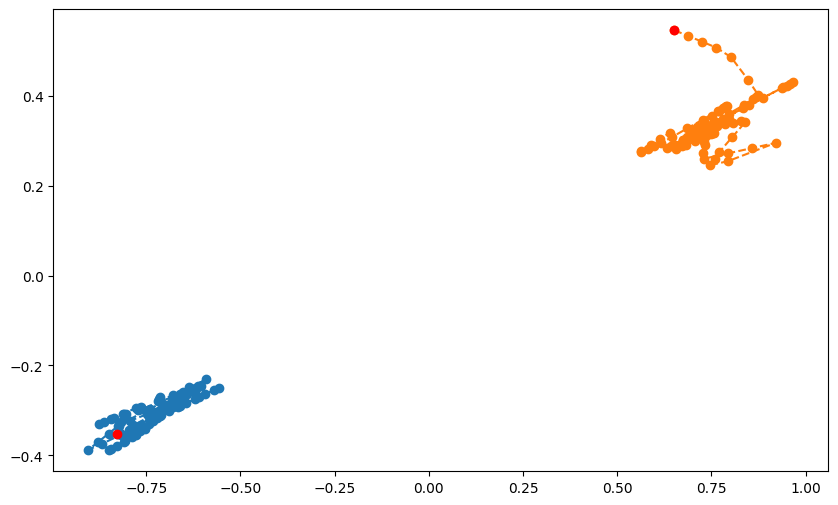

In [320]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

wifi_xs_1, wifi_ys_1 = normalize(straight_line_segments[1], n_points=90, filter_func=None)
wifi_xs_2, wifi_ys_2 = normalize(straight_line_segments[2], n_points=90, filter_func=None)

ax.plot(wifi_xs_1, wifi_ys_1, marker="o", ls="--")
ax.plot(wifi_xs_2, wifi_ys_2, marker="o", ls="--")

ax.plot(wifi_xs_1[0], wifi_ys_1[0], marker="o", ls="--", color="red")
ax.plot(wifi_xs_2[0], wifi_ys_2[0], marker="o", ls="--", color="red")

In [285]:
from simplification.cutil import (
    simplify_coords,
    simplify_coords_idx,
    simplify_coords_vw,
    simplify_coords_vw_idx,
    simplify_coords_vwp,
)

In [321]:
line_1 = simplify_coords(straight_line_segments[1].rel_step_positions[:, 1:], 0.05)
line_2 = simplify_coords(straight_line_segments[2].rel_step_positions[:, 1:], 0.05)

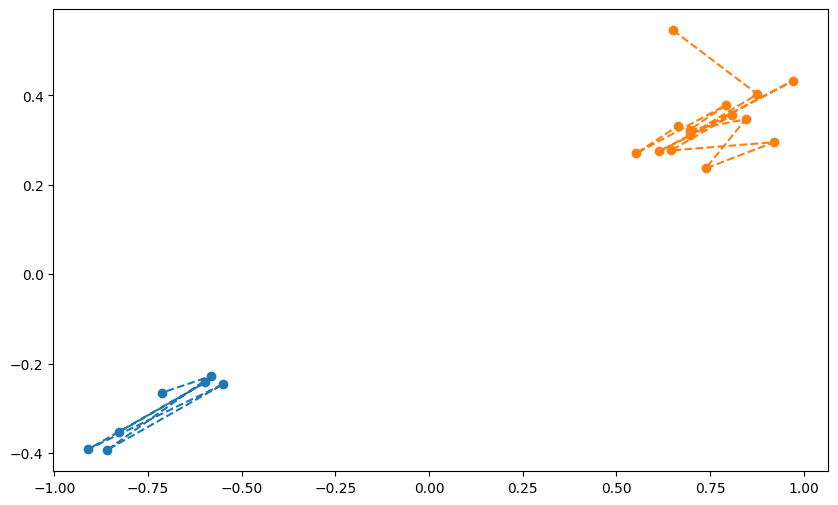

In [322]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

ax.plot(line_1[:, 0], line_1[:, 1], marker="o", ls="--")
ax.plot(line_2[:, 0], line_2[:, 1], marker="o", ls="--")


In [323]:
compute_path_correlation(straight_line_segments[1].step_positions[:, 1], 
                         straight_line_segments[1].step_positions[:, 2], 
                         straight_line_segments[2].step_positions[:, 1], 
                         straight_line_segments[2].step_positions[:, 2],)

-1.9756760858856723

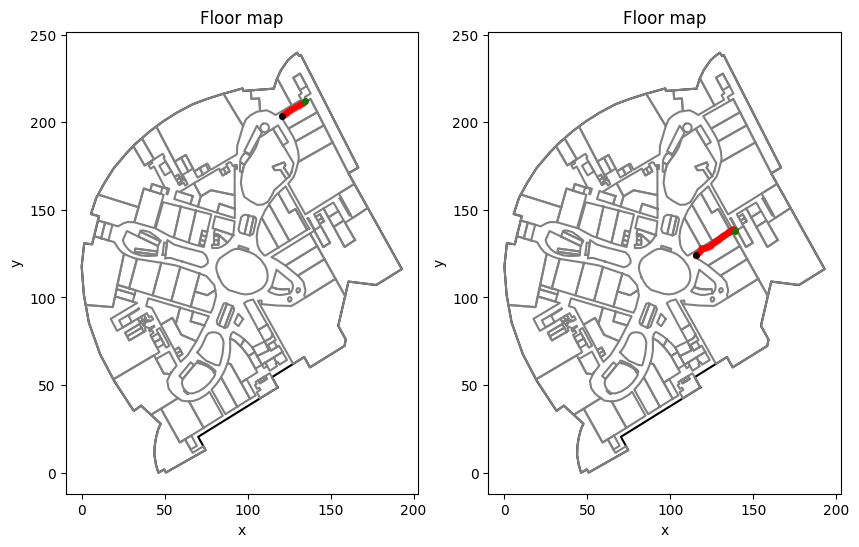

In [349]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))

plot_floor_map(floor_polygons, store_polygons, ax=ax1)
plot_floor_map(floor_polygons, store_polygons, ax=ax2)

waypoint_location = transform_func(straight_line_segments[1].step_positions[:, 1:])
plot_waypoint_location(waypoint_location, ax=ax1, plot_kwargs={"label": "train", "ls": "--"})

waypoint_location = transform_func(straight_line_segments[3].step_positions[:, 1:])
plot_waypoint_location(waypoint_location, ax=ax2, plot_kwargs={"label": "train", "ls": "--"})

plt.ticklabel_format(useOffset=False)
plt.show()

In [394]:
def compute_segment_length(segment: Segment) -> float:
  locations = segment.rel_step_positions[:, 1:]

  return np.linalg.norm(locations[1:] - locations[:-1], axis=1).sum()

In [481]:
turn_stats = []
for turn_segment in turn_segments:

  turn_stats.append((compute_segment_length(turn_segment), turn_segment.rel_step_positions.shape[0]))

In [482]:
df = pd.DataFrame(turn_stats, columns=["length", "n_steps"])

In [483]:
df[df["n_steps"] <= 31]["length"].mean(), df[df["n_steps"] <= 31]["length"].std()

(5.018201973585796, 2.4635708736085666)

In [484]:
df["length"].mean(), df["length"].std()

(5.3429133025503734, 3.1363060041054363)

In [485]:
turns_f = [turn_segments[i] for i in df[df["n_steps"] <= 31].index.values]

* TODO: Scale to the same length to compute the correlation

(16.48587597488924, 45)

In [398]:
compute_segment_length(straight_line_segments[37]), straight_line_segments[37].rel_step_positions.shape[0]

(11.521863917912505, 43)

In [407]:
compute_path_correlation_max(straight_line_segments[54].rel_step_positions[:, 1],
                         straight_line_segments[54].rel_step_positions[:, 2],
                         straight_line_segments[55].rel_step_positions[::-1, 1],
                         straight_line_segments[55].rel_step_positions[::-1, 2])

0.7915833587250191

In [256]:
len(turn_segments)

319